In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import yfinance
import pandas_datareader as pdr

import cvxportfolio as cp

Download the problem data from Yfinance. We select four liquid stocks, and the risk-free rate.

In [3]:
tickers = ['AMZN', 'GOOGL', 'TSLA', 'NKE']
start_date='2012-01-01'
end_date='2016-12-31'
returns = pd.DataFrame(dict([(ticker, yfinance.download(ticker)['Adj Close'].pct_change())
                for ticker in tickers]))
    
returns["USDOLLAR"]=pdr.get_data_fred('DFF', start="1900-01-01", 
                                        end=pd.Timestamp.today())['DFF']/(252*100)

returns = returns.fillna(method='ffill').iloc[1:]

returns.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,AMZN,GOOGL,TSLA,NKE,USDOLLAR
Date,,,,,
2023-04-27,0.046104,0.037412,0.041886,0.015019,0.000192
2023-04-28,-0.039792,-0.002324,0.025719,0.008115,0.000192
2023-05-01,-0.032243,-0.001304,-0.015093,0.009470,0.000192
2023-05-02,0.015483,-0.017537,-0.009393,-0.005159,0.000192
2023-05-03,0.015483,0.019370,-0.009393,0.007151,0.000192


We compute rolling estimates of the first and second moments of the returns using a window of 250 days. We shift them by one unit (so at every day we present the optimizer with only past data).

In [4]:
r_hat = returns.rolling(window=250).mean().shift(1).dropna()
Sigma_hat = returns.rolling(window=250).cov().shift(5).dropna()

r_hat.tail()

,AMZN,GOOGL,TSLA,NKE,USDOLLAR
Date,,,,,
2023-04-27,-0.000645,-0.000089,-0.001724,0.000439,0.000123
2023-04-28,-0.000646,-0.000088,-0.001538,0.000308,0.000124
2023-05-01,-0.000243,0.000052,-0.001404,0.000414,0.000124
2023-05-02,-0.000379,-0.000040,-0.001613,0.000408,0.000125
2023-05-03,-0.000310,-0.000136,-0.001678,0.000489,0.000126


In [5]:
tcost_model=cp.TcostModel(half_spread=10E-4)
hcost_model=cp.HcostModel(borrow_costs=1E-4)

Here we define the transaction cost and holding cost model (sections 2.3 and 2.4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). The data can be expressed 
as 
- a scalar (like we're doing here), the same value for all assets and all time periods;
- a Pandas Series indexed by the asset names, for asset-specific values; 
- a Pandas DataFrame indexed by timestamps with asset names as columns, for values that vary by asset and in time.

We define the single period optimization policy (section 4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). 

In [6]:
risk_model = cp.FullSigma(Sigma_hat)
gamma_risk, gamma_trade, gamma_hold = 5., 1., 1.
leverage_limit = cp.LeverageLimit(3)

spo_policy = cp.SinglePeriodOpt(return_forecast=r_hat, 
                                costs=[gamma_risk*risk_model, gamma_trade*tcost_model, gamma_hold*hcost_model],
                                constraints=[leverage_limit])

We run a backtest, which returns a result object. By calling its summary method we get some basic statistics.

In [7]:
market_sim=cp.MarketSimulator(returns, [tcost_model, hcost_model], cash_key='USDOLLAR') 
init_portfolio = pd.Series(index=returns.columns, data=250000.)
init_portfolio.USDOLLAR = 0
results = market_sim.run_multiple_backtest(init_portfolio,
                               start_time='2013-01-03',  end_time='2016-12-31',  
                               policies=[spo_policy, cp.Hold()])
results[0].summary()

Number of periods                              1007
Initial timestamp               2013-01-03 00:00:00
Final timestamp                 2016-12-30 00:00:00
Portfolio return (%)                         23.451
Excess return (%)                            23.270
Excess risk (%)                              21.298
Sharpe ratio                                  1.093
Max. drawdown                                20.050
Turnover (%)                                 93.553
Average policy time (sec)                     0.030
Average simulator time (sec)                  0.002


The total value of the portfolio in time.

<AxesSubplot:>

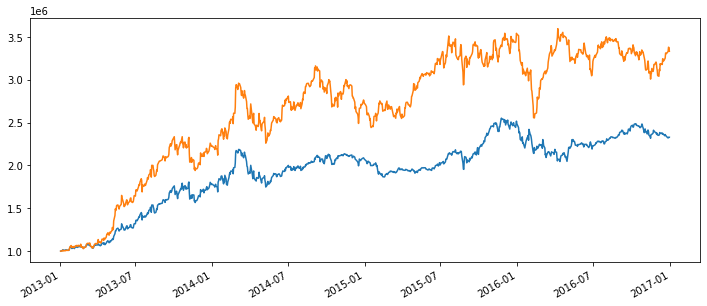

In [8]:
results[0].v.plot(figsize=(12,5))
results[1].v.plot(figsize=(12,5))

The weights vector of the portfolio in time.

<AxesSubplot:>

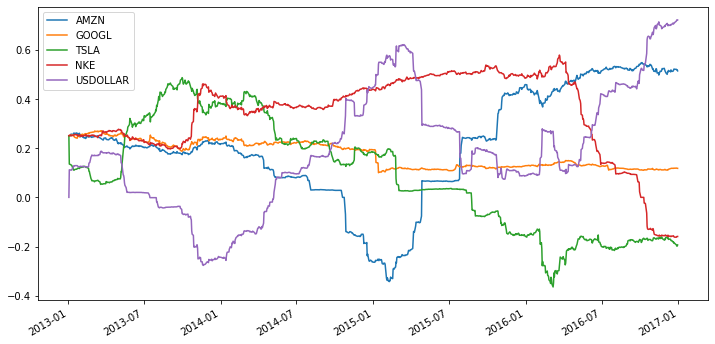

In [9]:
results[0].w.plot(figsize=(12,6))